In [14]:
from mri.ExplainableAI import *
import matplotlib.pyplot as plt


#### Load trained models from Gatshub

In [3]:
import mlflow
import os

# Set the tracking URI for your DagsHub repository
mlflow.set_tracking_uri("https://dagshub.com/samisena/MRI_VScode.mlflow")

# Set your DagsHub credentials
os.environ['MLFLOW_TRACKING_USERNAME'] = 'samisena'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'cb6584b07822e49dbde524fb92b0376756fcfdfd'


In [4]:
run_id = "4a013ab305c843f1a5b073e13387c25f"
model_uri = f"runs:/{run_id}/model"

In [ ]:

# Now try to load the model
model_uri = f"runs:/{run_id}/model"
try:
    loaded_model = mlflow.pytorch.load_model(model_uri)
    print("Model loaded successfully!")
    # Verify the model structure
    print(type(loaded_model))
    print(loaded_model)
except Exception as e:
    print(f"Error loading model: {e}")

c:\ProgramData\anaconda3\envs\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [9]:
# Get run data including metrics, params, and tags
run = client.get_run(run_id)
print("Run data:")
print("Parameters:", run.data.params)
print("Metrics:", run.data.metrics)
print("Tags:", run.data.tags)

# Try listing available artifacts without downloading
artifacts = client.list_artifacts(run_id)
print("\nAvailable artifacts:")
for artifact in artifacts:
    print(f"- {artifact.path}")
    
    # If this is a directory, list its contents too
    if artifact.is_dir:
        sub_artifacts = client.list_artifacts(run_id, artifact.path)
        for sub_artifact in sub_artifacts:
            print(f"  - {sub_artifact.path}")

Run data:
Parameters: {'epochs': '100', 'patience': '10', 'checkpoint_freq': '5', 'learning_rate': '0.003'}
Metrics: {'best_accuracy': 98.48308051341891}
Tags: {'mlflow.user': 'samisena', 'mlflow.source.name': '/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/ipykernel_launcher.py', 'mlflow.source.type': 'LOCAL', 'mlflow.runName': 'resnet50', 'mlflow.log-model.history': '[{"run_id": "4a013ab305c843f1a5b073e13387c25f", "artifact_path": "final_model_resnet50", "utc_time_created": "2025-03-18 18:21:51.282229", "model_uuid": "bc248873a6ed472fad01f50904e6b3fc", "flavors": {"pytorch": {"model_data": "data", "pytorch_version": "2.2.1+cu121", "code": null}, "python_function": {"pickle_module_name": "mlflow.pytorch.pickle_module", "loader_module": "mlflow.pytorch", "python_version": "3.10.10", "data": "data", "env": {"conda": "conda.yaml", "virtualenv": "python_env.yaml"}}}}]'}

Available artifacts:
- final_model_resnet50
  - final_model_resnet50/MLmodel
  - final_model_resnet

In [10]:
# Load the model using the correct artifact path
model_uri = f"runs:/{run_id}/final_model_resnet50"
try:
    loaded_model = mlflow.pytorch.load_model(model_uri)
    print("Model loaded successfully!")
    print(type(loaded_model))
    print(loaded_model)
except Exception as e:
    print(f"Error loading model: {e}")

c:\ProgramData\anaconda3\envs\myvenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/04/16 12:13:31 WARNING mlflow.pytorch: Stored model version '2.2.1+cu121' does not match installed PyTorch version '2.5.1'


Error loading model: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.


In [12]:
run_id = "4a013ab305c843f1a5b073e13387c25f"
model_uri = f"runs:/{run_id}/final_model_resnet50"

# Load the model with map_location parameter to handle CUDA/CPU mismatch
import torch
loaded_model = mlflow.pytorch.load_model(model_uri, map_location=torch.device('cpu'))

# Set to evaluation mode
loaded_model.eval()
print("Model loaded successfully!")

2025/04/16 12:16:00 WARNING mlflow.pytorch: Stored model version '2.2.1+cu121' does not match installed PyTorch version '2.5.1'


Model loaded successfully!


#### Inference

In [15]:
#* Get one batch from the test loader
inputs, labels = next(iter(test_loader))
inputs[0].shape

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000028A0F7B9360>
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\envs\myvenv\lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\ProgramData\anaconda3\envs\myvenv\lib\site-packages\torch\utils\data\dataloader.py", line 1568, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "c:\ProgramData\anaconda3\envs\myvenv\lib\multiprocessing\process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "c:\ProgramData\anaconda3\envs\myvenv\lib\multiprocessing\popen_spawn_win32.py", line 108, in wait
    res = _winapi.WaitForSingleObject(int(self._handle), msecs)
KeyboardInterrupt: 


torch.Size([3, 224, 224])

In [5]:
inputs[0].unsqueeze(0).shape

torch.Size([1, 3, 224, 224])

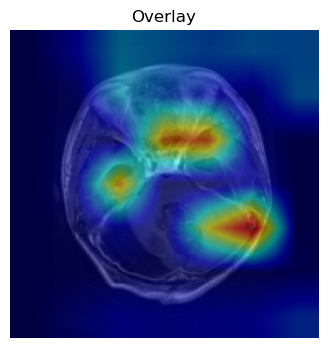

In [16]:

#* Get one batch from the test loader
inputs, labels = next(iter(test_loader))

#* Select the first image in the batch (and add a batch dimension if necessary)
input_tensor = inputs[0].unsqueeze(0)

loaded_model.eval()  # Ensure it's in evaluation mode

#* Define your target layer, e.g., "resnet.layer4"
target_layer = "resnet.layer4"
# — compute gradcam + overlay —
# get one batch
inputs, _ = next(iter(test_loader))
input_tensor = inputs[0].unsqueeze(0)

# run gradcam
heatmap, overlay = gradcam(
    loaded_model,
    target_layer="resnet.layer4",
    input_tensor=input_tensor,
    alpha=0.5
)

# display
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

#plt.subplot(1,2,1)
#plt.title("Grad‑CAM (inverted)")
#plt.imshow(1 - heatmap, cmap="jet")
#plt.colorbar()
#plt.axis("off")

# Your unchanged overlay
# plt.subplot(1,2,2)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

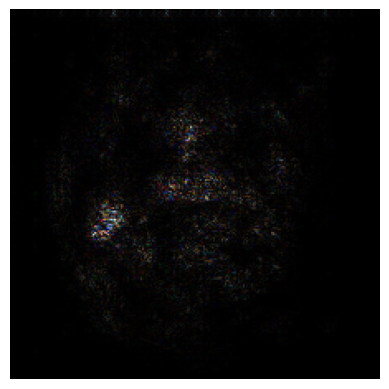

In [17]:
#* Instantiate your model (and load your weights if needed)
loaded_model.eval()  # Ensure it's in evaluation mode
#* get one batch
inputs, _ = next(iter(test_loader))
input_tensor = inputs[0].unsqueeze(0)

guided_bp = guided_backprop(loaded_model, input_tensor)
plt.imshow(guided_bp)
plt.axis('off')